Load required libraries

In [1]:
using Random
using CairoMakie
using Turing, KernelFunctions, NNlib, SpecialFunctions
using StatsFuns: logistic, norminvcdf
using Memoization, ReverseDiff

## Periodic Activations Function

We will first define the periodic functions described in the manuscript. We refer to the appendix for details on the correct scaling.

In [2]:
const triangleconst = π/(2*sqrt(2))
const preluconst = π/4
_trianglewave(x) = (x - π * floor(x/π + 0.5)) * (-1)^floor(x/π + 0.5)
_trianglewave(x::ReverseDiff.TrackedReal) = ReverseDiff.ForwardOptimize(_trianglewave)(x)

heaviside(x) = x < zero(x) ? zero(x) : x >= zero(x) ? one(x) : oftype(x,0.5)
lsmatern(x, q, ν, λ) = q*heaviside(x)*x^(ν-1/2)*exp(-λ*x)
heaviside(x::ReverseDiff.TrackedReal) = ReverseDiff.ForwardOptimize(heaviside)(x)

heaviside (generic function with 2 methods)

In [3]:
abstract type PeriodicFunction end

hasBias(::PeriodicFunction) = true

struct SinActivation <: PeriodicFunction end
const sineconst = sqrt(2)
(σ::SinActivation)(x::T) where T = T(sineconst) * sin(x)

struct SinCosActivation <: PeriodicFunction end
(σ::SinCosActivation)(x) = sin(x) + cos(x)
hasBias(::SinCosActivation) = false

struct TriangleWave <: PeriodicFunction end
(σ::TriangleWave)(x) = triangleconst * _trianglewave(x)

struct PeriodicReLU <: PeriodicFunction end
(σ::PeriodicReLU)(x) = preluconst * (_trianglewave(x) + _trianglewave(x + π/2))

In [4]:
abstract type ActivationFunction end

struct RBF <: ActivationFunction
    σ::PeriodicFunction
end
(σ::RBF)(x) = σ.σ(x)
prior_weights(::RBF) = Normal()
prior_bias(::RBF) = Uniform(-π, π)

struct Matern <: ActivationFunction
    σ::PeriodicFunction
    ν # smoothness
end
(σ::Matern)(x) = σ.σ(x)
prior_weights(σ::Matern) = σ.ν == 0.5 ? Cauchy() : TDist(2*σ.ν)
prior_bias(::Matern) = Uniform(-π, π)

prior_bias (generic function with 2 methods)

## Visualisations

Next we will visualize the different activation functions over two periods.

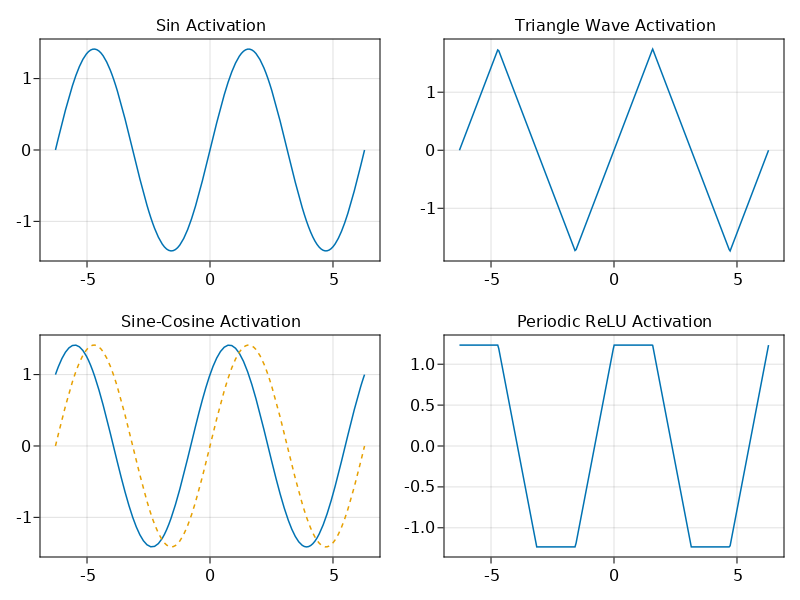

In [5]:
fig = Figure()

ax1 = fig[1,1] = Axis(fig, title = "Sin Activation")
lines!(ax1, -2*π..2π, x -> SinActivation()(x))

ax2 = fig[2,1] = Axis(fig, title = "Sine-Cosine Activation")
lines!(ax2, -2*π..2π, x -> SinCosActivation()(x))
lines!(ax2, -2*π..2π, x -> SinActivation()(x), linestyle = :dash)

ax3 = fig[1,2] = Axis(fig, title = "Triangle Wave Activation")
lines!(ax3, -2*π..2π, x -> TriangleWave()(x))

ax4 = fig[2,2] = Axis(fig, title = "Periodic ReLU Activation")
lines!(ax4, -2*π..2π, x -> PeriodicReLU()(x))

fig

## Covariance

Next we will estimate the induced covariance structure using MC integration and match it to the exact solutions.

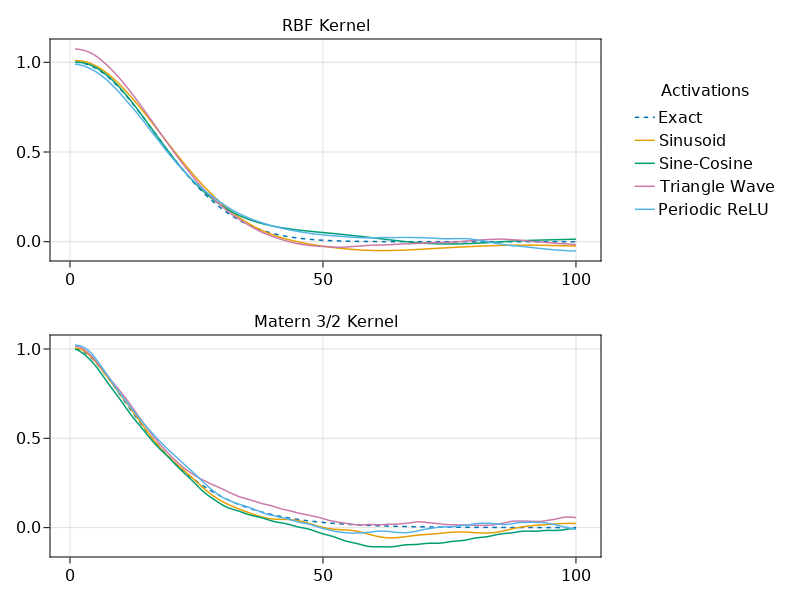

In [7]:
function κ(x, y, afun; samples = 1000)
    
    b = hasBias(afun.σ) ? rand(prior_bias(afun), 1, samples) : 0.0
    w = rand(prior_weights(afun), samples)
    
    
    vec(mean(afun.(x * w' .+ b) .* afun.(y * w' .+ b), dims=2))
end



x = collect(range(0, 2*π, length=500))


fig = Figure()

ax1 = fig[1,1] = Axis(fig, title = "RBF Kernel")

k = SqExponentialKernel()
K = kernelmatrix(k,reshape(x, :, 1),obsdim=1)

lines!(ax1, 1..100, K[1,:], linestyle = :dash, label = "Exact")
lines!(ax1, 1..100, κ(x, x[1], RBF(SinActivation())), label = "Sinusoid")
lines!(ax1, 1..100, κ(x, x[1], RBF(SinCosActivation())), label = "Sine-Cosine")
lines!(ax1, 1..100, κ(x, x[1], RBF(TriangleWave())), label = "Triangle Wave")
lines!(ax1, 1..100, κ(x, x[1], RBF(PeriodicReLU())), label = "Periodic ReLU")

ax2 = fig[2,1] = Axis(fig, title = "Matern 3/2 Kernel")

k = Matern32Kernel()
K = kernelmatrix(k,reshape(x, :, 1),obsdim=1)

lines!(ax2, 1..100, K[1,:], linestyle = :dash, label = "Exact")
lines!(ax2, 1..100, κ(x, x[1], Matern(SinActivation(), 3/2)), label = "Sinusoid")
lines!(ax2, 1..100, κ(x, x[1], Matern(SinCosActivation(), 3/2)), label = "Sine-Cosine")
lines!(ax2, 1..100, κ(x, x[1], Matern(TriangleWave(), 3/2)), label = "Triangle Wave")
lines!(ax2, 1..100, κ(x, x[1], Matern(PeriodicReLU(), 3/2)), label = "Periodic ReLU")

fig[1,2] = Legend(fig, ax1, "Activations", framevisible = false)

fig

We can also directly visualize the Gram matrix.

In [8]:
x = collect(range(0, 2*π, length=50))
G₁ = mapreduce(xi -> κ(x, xi, Matern(SinActivation(), 1/2)), hcat, x)
G₂ = mapreduce(xi -> κ(x, xi, Matern(SinActivation(), 3/2)), hcat, x)
G₃ = mapreduce(xi -> κ(x, xi, RBF(SinActivation())), hcat, x);

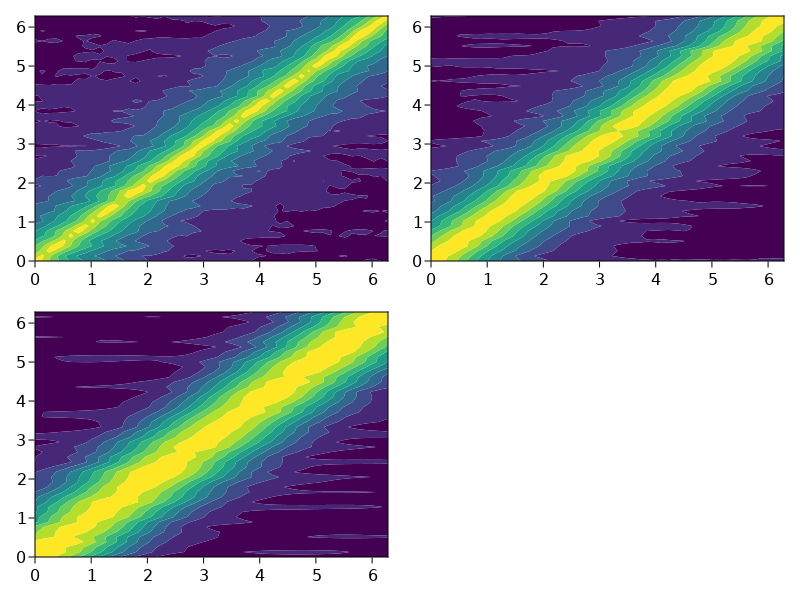

In [9]:
f = Figure()
ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])
ax3 = Axis(f[2,1])

contourf!(ax1, x, x, G₁)
contourf!(ax2, x, x, G₂)
contourf!(ax3, x, x, G₃)

f

## Regression

In the next section of the notebook, we will use a stationary inducing 

In [10]:
N = 20
xs = (rand(N) * 2) .- 2
ys = exp.(abs.(xs)) 

ys .+= randn(N) * 0.1;
ys .-= mean(ys)
ys /= var(ys);

In [11]:
@model function bnn(x, y, afun, K)
    
    w ~ filldist(prior_weights(afun), 1, K)
    b ~ filldist(prior_bias(afun), 1, K)
    
    l ~ truncated(Normal(1,5), 0, Inf)
    
    z = afun.(x * l * w .+ b)
    
    wo ~ filldist(Normal(), K)
    bo ~ Normal()
    
    f = (z * (wo / sqrt(K)) .+ bo)
    
    Turing.@addlogprob! -sum(abs2(yj-fj) for (fj,yj) in zip(f,y))
end

bnn (generic function with 1 method)

In [12]:
Turing.setadbackend(:reversediff)
Turing.setrdcache(true);

In [13]:
function predict(xtest, afun, K, chain; burnin = 1)
    
    w_names = filter(n -> contains(string(n), "w["), names(chain))
    wo_names = filter(n -> contains(string(n), "wo["), names(chain))
    b_names = filter(n -> contains(string(n), "b["), names(chain))
    
    w = chain[w_names]
    b = chain[b_names]
    wo = chain[wo_names]
    bo = chain["bo"]
    l = chain["l"]
    
    nsamples = length(w)
    
    latents = map(s -> begin
            w_ = Array(w[s])
            b_ = Array(b[s])
            
            wo_ = vec(Array(wo[s]))
            bo_ = bo[s]
            
            l_ = l[s]
            
            z = afun.(xtest * w_ * l_ .+ b_)
            f = (z * (wo_ / sqrt(K)) .+ bo_)
        end, burnin:nsamples)
    
    err_o = 1.96*sqrt.(var(latents)) .+ 1
    err = 1.96*std(latents)
    
    return mean(latents), err, err_o
end

predict (generic function with 1 method)

In [14]:
model = bnn(xs, ys, Matern(PeriodicReLU(), 3/2), 10);
chain = sample(model, NUTS(1000, 0.8), 4000);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /u/54/meronel1/unix/.julia/packages/Turing/28kgo/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /u/54/meronel1/unix/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling:  17%|███████                                  |  ETA: 0:12:54┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /u/54/meronel1/unix/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
Sampling: 100%|█████████████████████████████████████████| Time: 0:16:20


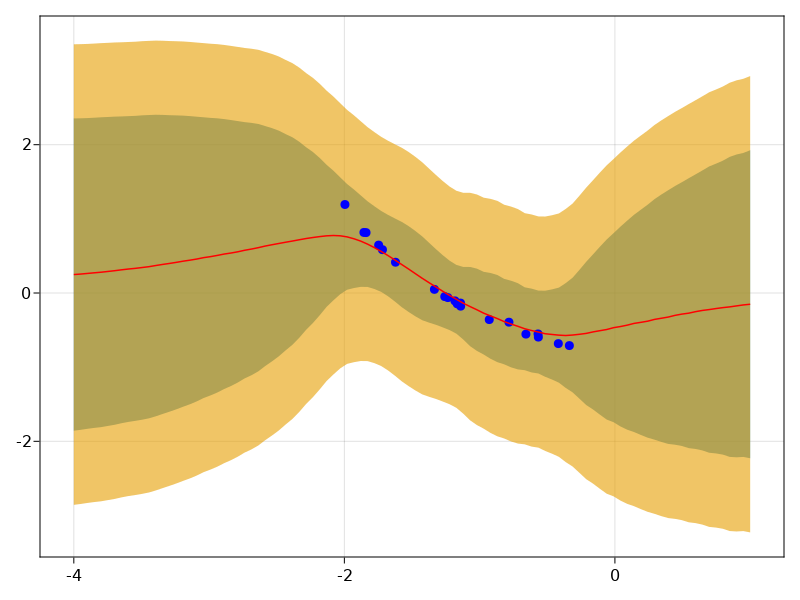

In [15]:
xt = collect(range(-4, 1, length = 100))

yhat, σf, σo = predict(xt, Matern(PeriodicReLU(), 3/2), 10, chain);

f = Figure()
Axis(f[1, 1])

band!(xt, yhat + σf, yhat - σf)
band!(xt, yhat + σo, yhat - σo)
scatter!(xs, ys, color = :blue)
lines!(xt, yhat, color = :red)

f